In [3]:
import numpy as np
import matplotlib.pyplot as plt
from molecule import CaOH, CaH, mu_N, gI
from scipy.constants import h, k
%matplotlib inline

import qls
import utils as ut

In [3]:
# Taken from Chou et al.

gj_list: list[float] = [-1.35, -1.35, -1.35, -1.34, -1.34, -1.34, -1.34, -1.34, -1.33, -1.33, -1.33, -1.32, -1.32, -1.31, -1.31]

cij_list: list[float] = [8.27, 8.26, 8.26, 8.26, 8.26, 8.25, 8.25, 8.24, 8.24, 8.23, 8.22, 8.21, 8.20, 8.19, 8.18]

b_field_gauss = 3.6
j_max = 14

# mo1 = CaH.create_molecule_data(b_field_gauss=b_field_gauss, j_max=j_max)
mo1 = CaH.create_molecule_data(b_field_gauss=b_field_gauss, j_max=j_max, gj_list = gj_list, cij_list = cij_list)

temperature = 300
states1 = qls.States(mo1, temperature)


[0.00721205 0.00721205 0.00721205 0.00721205 0.00721205 0.00721205
 0.00721205 0.00721205 0.00721205 0.00721205 0.00721205 0.00721205
 0.00721205 0.00721205 0.00721205 0.00721205 0.00721205 0.00721205]
[0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556]


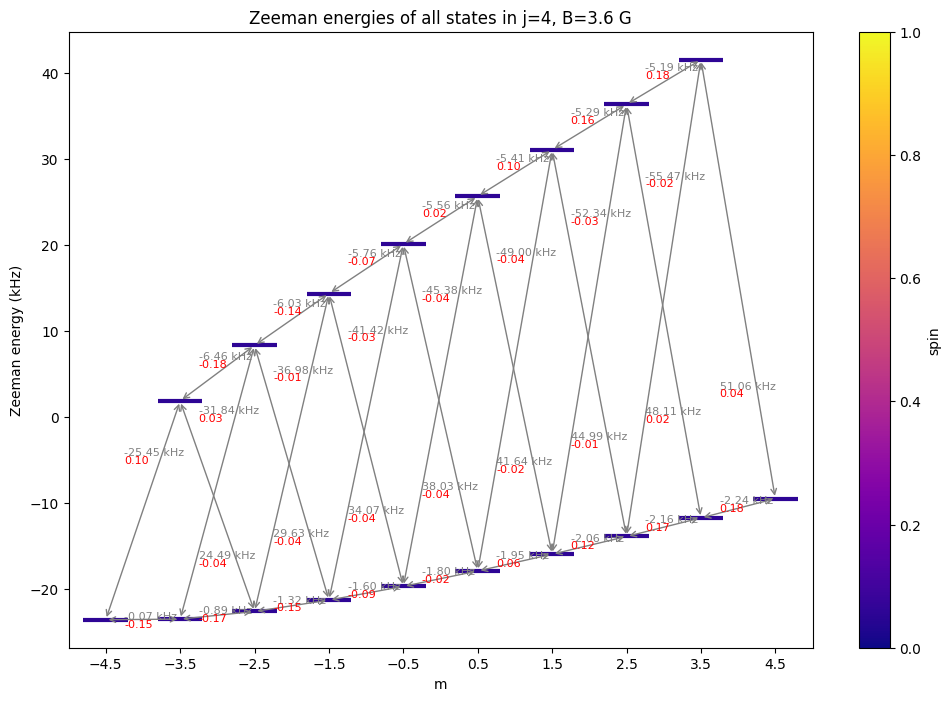

In [4]:
ut.plot_state_dist(mo1, 4)

[7.24967423e-02 1.89176736e-02 3.05507846e-03 2.30399022e-03
 4.77357988e-03 2.01401141e-02 7.39952843e-03 6.21359527e-04
 5.34498332e-05 5.08698166e-05 1.65847125e-06 9.88495951e-07
 8.16961660e-07 1.01655475e-06 4.46023677e-09 1.41607307e-10
 3.85641524e-53 2.28080378e-54]
[5.58453933e-01 1.45725847e-01 2.35337552e-02 1.77480030e-02
 3.67716448e-02 1.55142501e-01 5.69997440e-02 4.78643123e-03
 4.11732563e-04 3.91858285e-04 1.27754677e-05 7.61454148e-06
 6.29318556e-06 7.83068289e-06 3.43579130e-08 1.09082360e-09
 2.97065798e-52 1.75693942e-53]


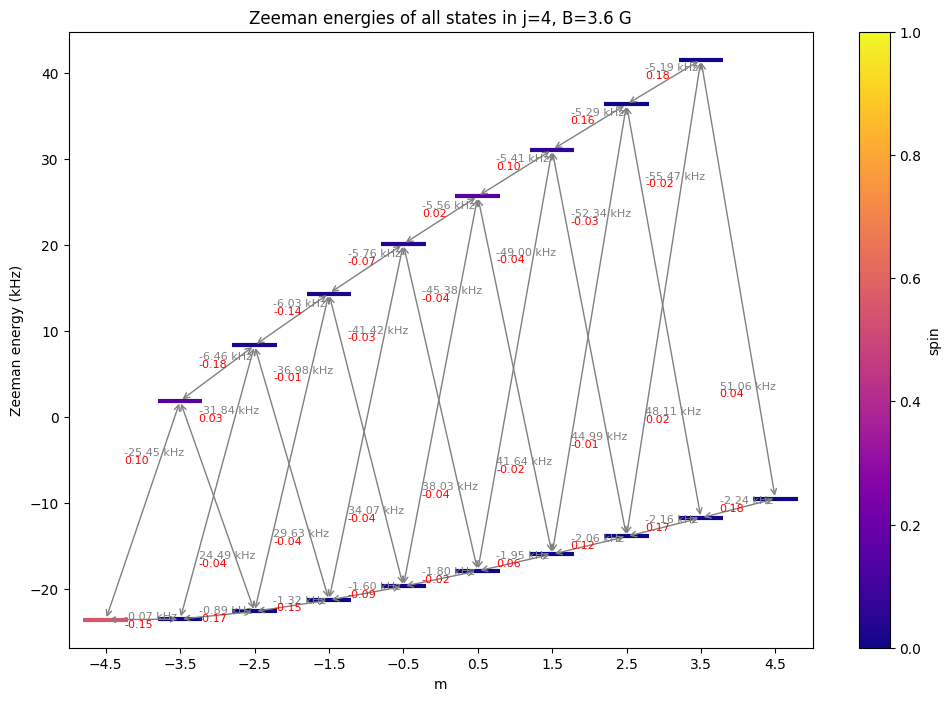

In [5]:
signature_transitions = np.array([mo1.transition_df.loc[mo1.transition_df["j"]==j].iloc[0]["energy_diff"] * 1e-3 for j in range(1, mo1.j_max+1)])


pump_list = {
    'pump_frequency_mhz': -0.002,
    'num_pumps': 200,
    'pump_duration_us': 1000.0,
    'pump_rabi_rate_mhz': 2*np.pi*0.004,
    'pump_dephased': True,
    'coherence_time_us': 100,
    'is_minus': True
}


qls.apply_pumping(mo1 = mo1, **pump_list, noise_params = None, seed = None)


ut.plot_state_dist(mo1, 4)

[7.44573304e-02 5.33385622e-02 7.94491604e-05 5.32106818e-05
 9.28186991e-05 1.75961358e-03 8.07008418e-17 2.27845074e-25
 9.23811762e-27 2.03298141e-05 2.10786716e-06 3.28748746e-06
 8.87195675e-06 1.27764152e-06 1.17179404e-08 1.05553206e-10
 1.99432677e-54 7.12118526e-56]
[5.73556654e-01 4.10875425e-01 6.12009515e-04 4.09890342e-04
 7.14997197e-04 1.35545832e-02 6.21651416e-16 1.75512683e-24
 7.11626888e-26 1.56603791e-04 1.62372359e-05 2.53240386e-05
 6.83420934e-05 9.84187579e-06 9.02651582e-08 8.13093125e-10
 1.53626162e-53 5.48556223e-55]


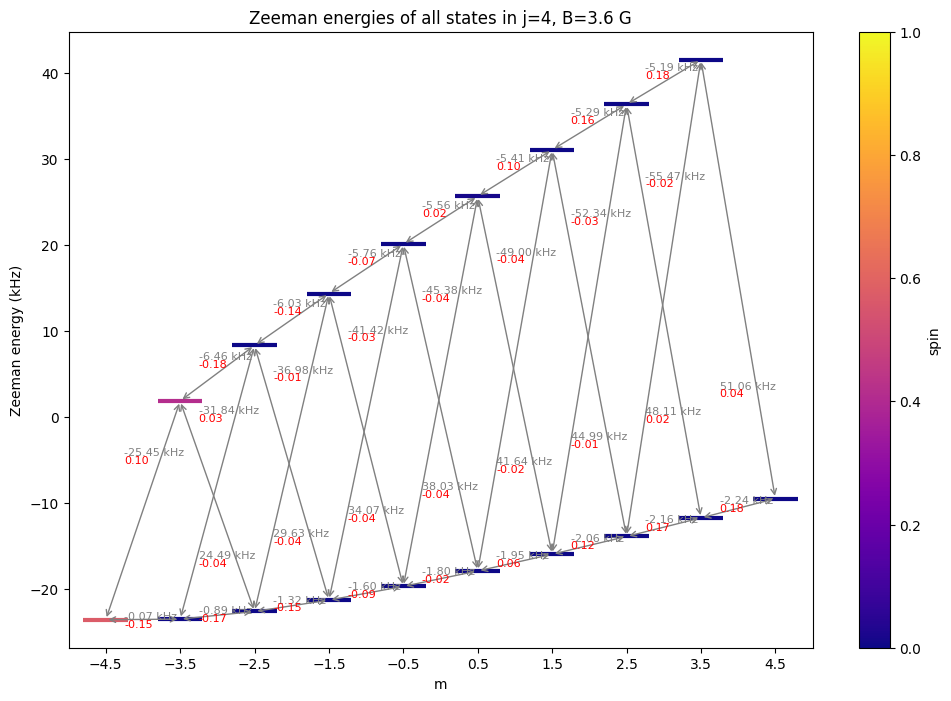

In [6]:
pump_list['pump_frequency_mhz'] = -0.006

qls.apply_pumping(mo1 = mo1, **pump_list, noise_params = None, seed = None)


ut.plot_state_dist(mo1, 4)

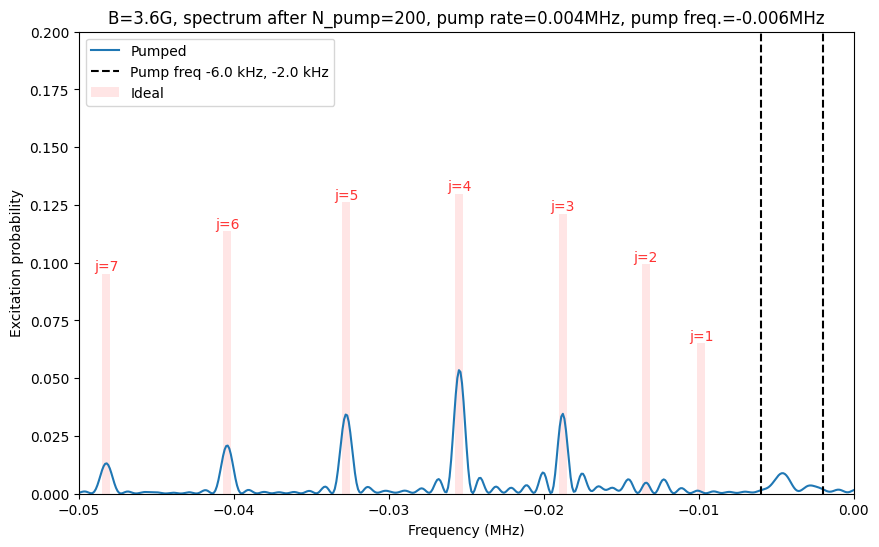

In [7]:
spectrum_list = {
    'duration_us': 1000,
    'rabi_rate_mhz': 2*np.pi*0.005,
    'max_frequency_mhz': 0.05,
    'scan_points': 1000,
    'dephased': False,
    'coherence_time_us': 100,
    'is_minus': True
}



fig, ax = plt.subplots(figsize=(10, 6))

frequencies, exc_probs1_after = qls.get_spectrum(molecule=mo1,state_distribution=mo1.state_df["state_dist"], **spectrum_list, noise_params=None, seed=None)

ax.plot(frequencies, exc_probs1_after, label = f"Pumped")      # Plot after pumping



ax.bar(signature_transitions, states1.j_distribution()[1:], color="red", width=0.0005, alpha=0.1, label = "Ideal")
ax.axvline(x=-0.002, color='black', linestyle='--')
ax.axvline(x=-0.006, color='black', linestyle='--', label=f'Pump freq {-0.006*(1e3)} kHz, {-0.002*(1e3)} kHz')
ax.legend()
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Excitation probability")
ax.set_title(f"B={b_field_gauss}G, spectrum after N_pump={pump_list['num_pumps']}, pump rate={pump_list['pump_rabi_rate_mhz']/(2*np.pi):.3f}MHz, pump freq.={pump_list['pump_frequency_mhz']}MHz")

a_lim = -spectrum_list['max_frequency_mhz']
b_lim = 0
ax.set_xlim([a_lim, b_lim])
ax.set_ylim([0, 0.2])

for i in range(j_max):
    if signature_transitions[i] >= a_lim and signature_transitions[i] <= b_lim:
        ax.text(signature_transitions[i], states1.j_distribution()[i+1], f"j={i+1}", ha='center', va='bottom', color='red', alpha=0.8)

plt.show()


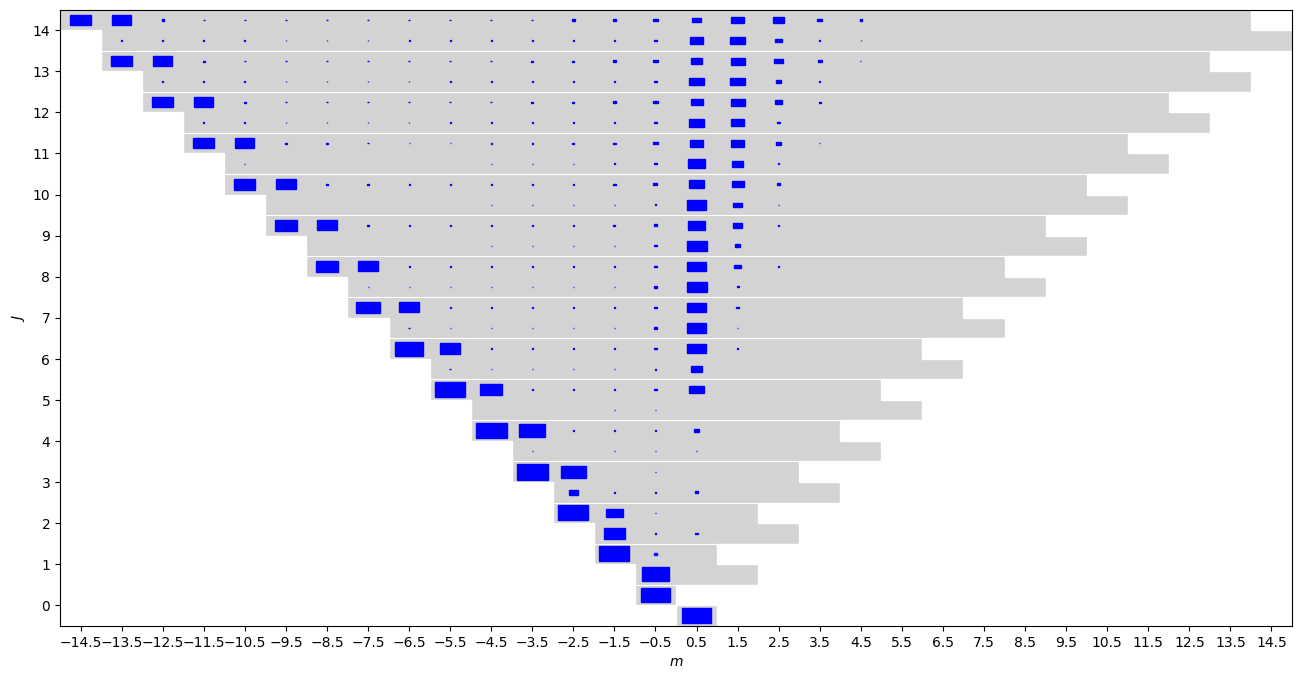

In [8]:
matrix = ut.heatmap_state_pop(mo1.state_df, j_max, normalize = True)

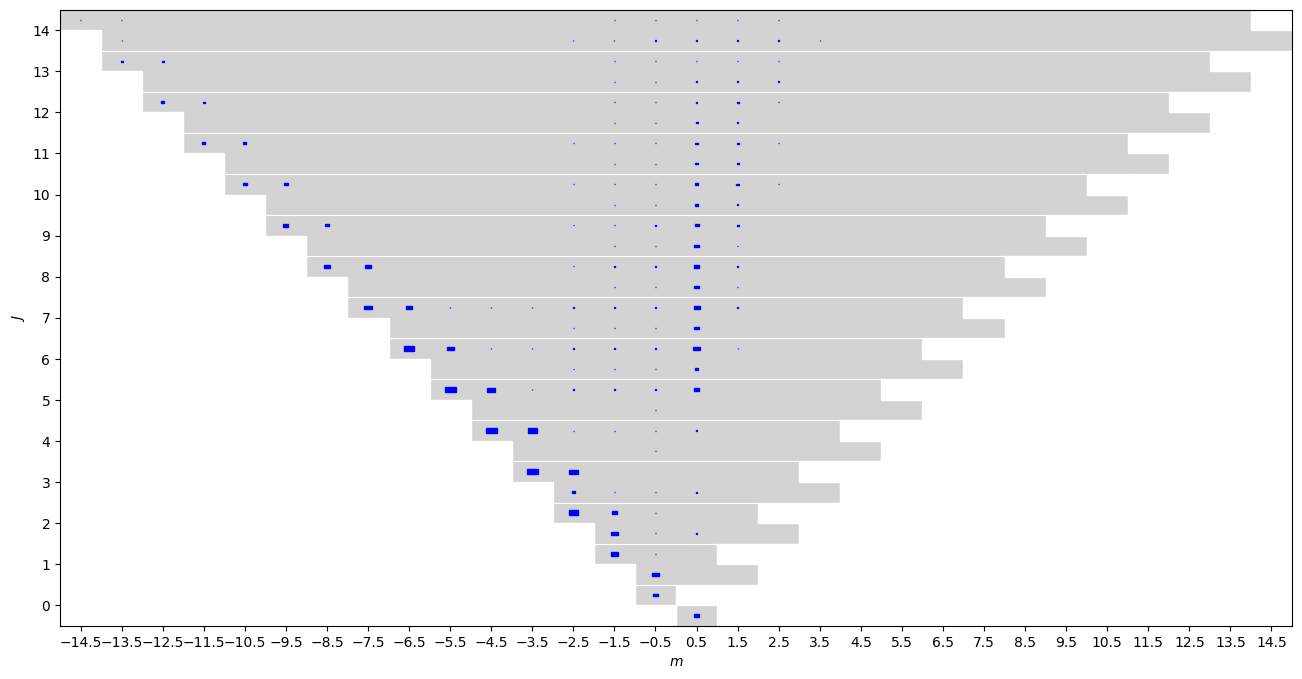

In [9]:
matrix = ut.heatmap_state_pop(mo1.state_df, j_max, normalize = False)

In [10]:
# matrix = heatmap_state_pop(mo1.state_df)

# CaOH

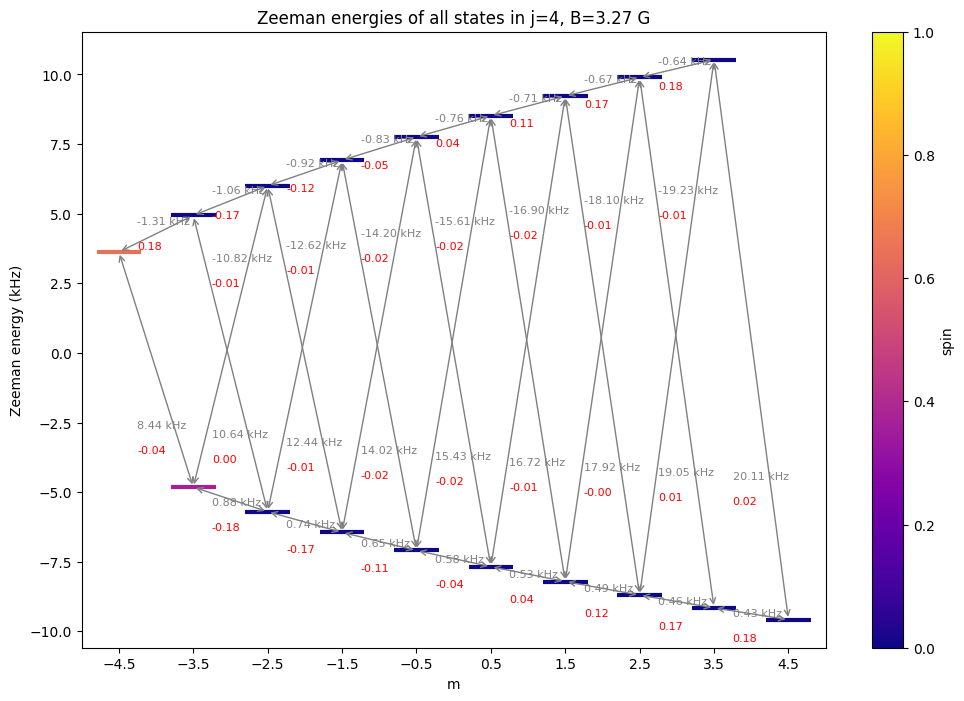

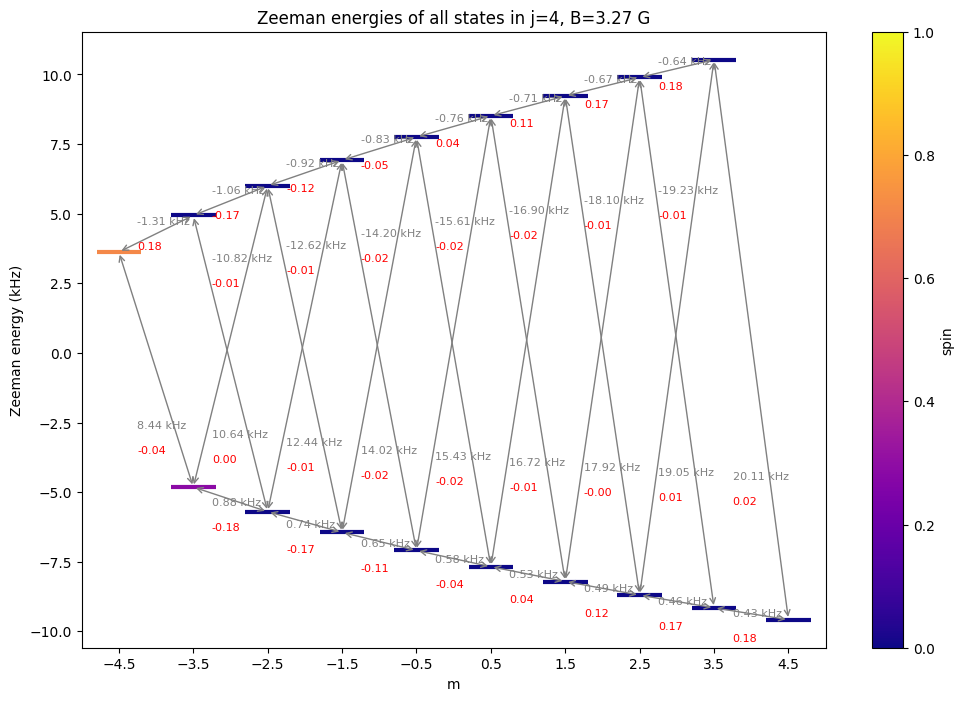

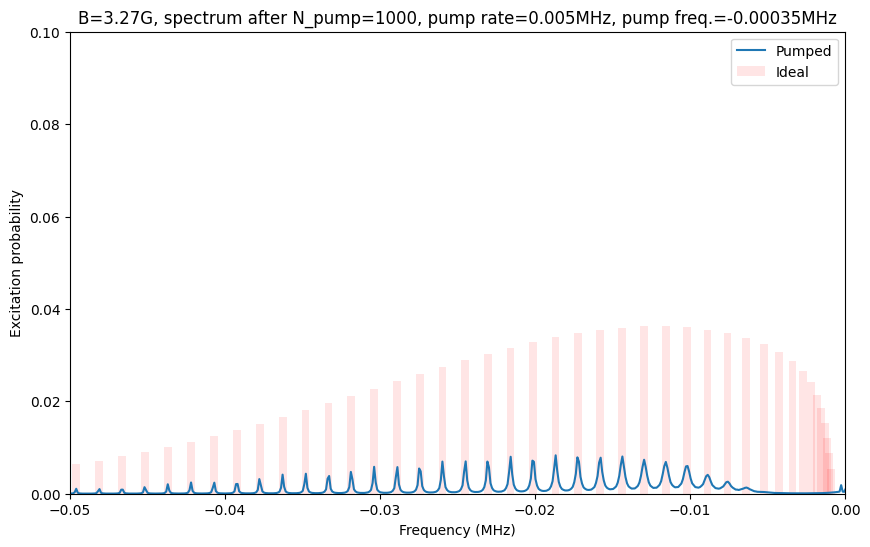

In [6]:
b_field_gauss = 3.27
j_max = 50

mo1 = CaOH.create_molecule_data(b_field_gauss=b_field_gauss, j_max=j_max)

temperature = 300
states1 = qls.States(mo1, temperature)


signature_transitions = np.array([mo1.transition_df.loc[mo1.transition_df["j"]==j].iloc[0]["energy_diff"] * 1e-3 for j in range(1, mo1.j_max+1)])


coherence_time_us = 1600
is_minus = True

spectrum_list = {
    'duration_us': 5000,
    'rabi_rate_mhz': 2*np.pi*0.005,
    'max_frequency_mhz': 0.05,
    'scan_points': 1000,
    'dephased': True,
    'coherence_time_us': coherence_time_us,
    'is_minus': is_minus
}


pump_list = {
    'pump_frequency_mhz': 0.00015,
    'num_pumps': 1000,
    'pump_duration_us': 1000.0,
    'pump_rabi_rate_mhz': 2*np.pi*0.005,
    'pump_dephased': True,
    'coherence_time_us': coherence_time_us,
    'is_minus': is_minus
}


qls.apply_pumping(molecule=mo1, **pump_list, noise_params = None, seed = None)
ut.plot_state_dist(mo1, 4)


pump_list['pump_frequency_mhz'] = -0.00035

qls.apply_pumping(molecule=mo1, **pump_list, noise_params = None, seed = None)
ut.plot_state_dist(mo1, 4)


frequencies, exc_probs1_after = qls.get_spectrum(molecule=mo1, state_distribution=mo1.state_df["state_dist"], **spectrum_list, noise_params = None, seed = None)



fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(frequencies, exc_probs1_after, label = f"Pumped")

ax.bar(signature_transitions, states1.j_distribution()[1:], color="red", width=0.0005, alpha=0.1, label = "Ideal")
# ax.axvline(x=pump_frequency_mhz_2, color='black', linestyle='--')
# ax.axvline(x=pump_frequency_mhz_1, color='black', linestyle='--', label=f'Pump freq {pump_frequency_mhz_1*(1e3)} kHz, {pump_frequency_mhz_2*(1e3)} kHz')
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Excitation probability")
ax.set_title(f"B={b_field_gauss}G, spectrum after N_pump={pump_list['num_pumps']}, pump rate={pump_list['pump_rabi_rate_mhz']/(2*np.pi):.3f}MHz, pump freq.={pump_list['pump_frequency_mhz']}MHz")

a_lim = -spectrum_list['max_frequency_mhz']
b_lim = 0

ax.set_xlim([a_lim, b_lim])
ax.set_ylim([0, 0.2])
ax.set_ylim(0,0.1)
ax.legend()
plt.show()

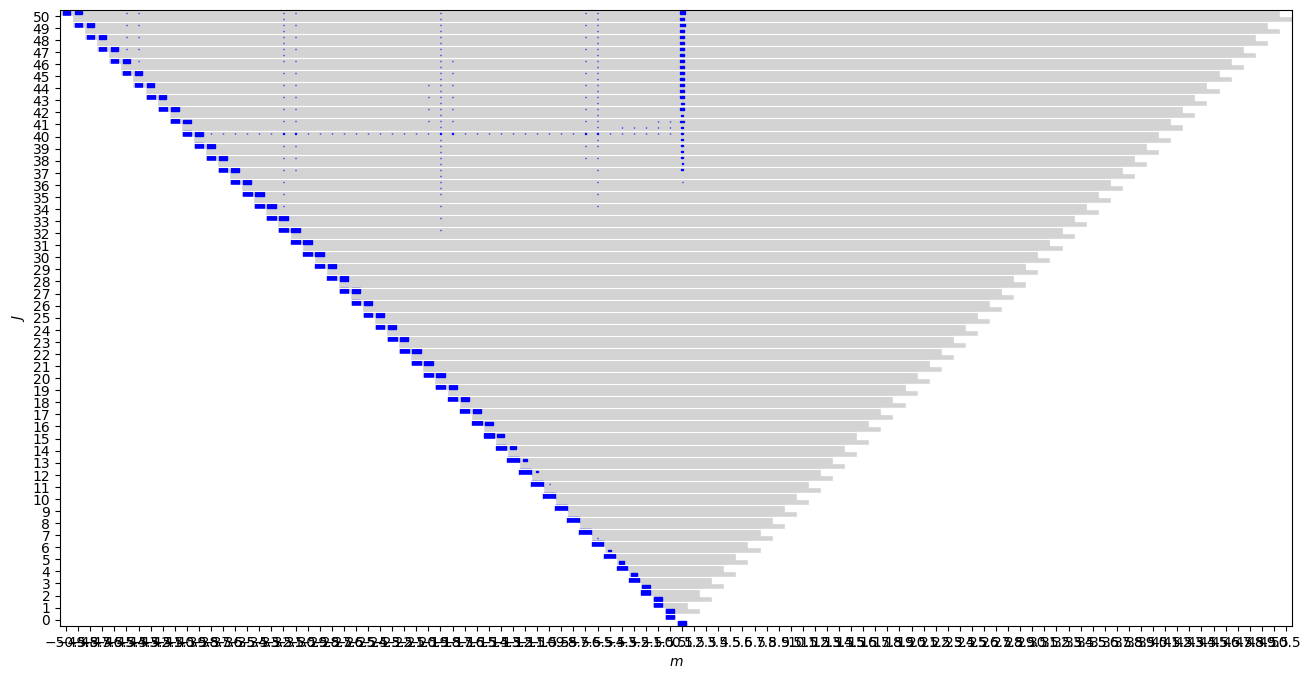

In [12]:
matrix = ut.heatmap_state_pop(mo1.state_df, j_max, normalize = True)

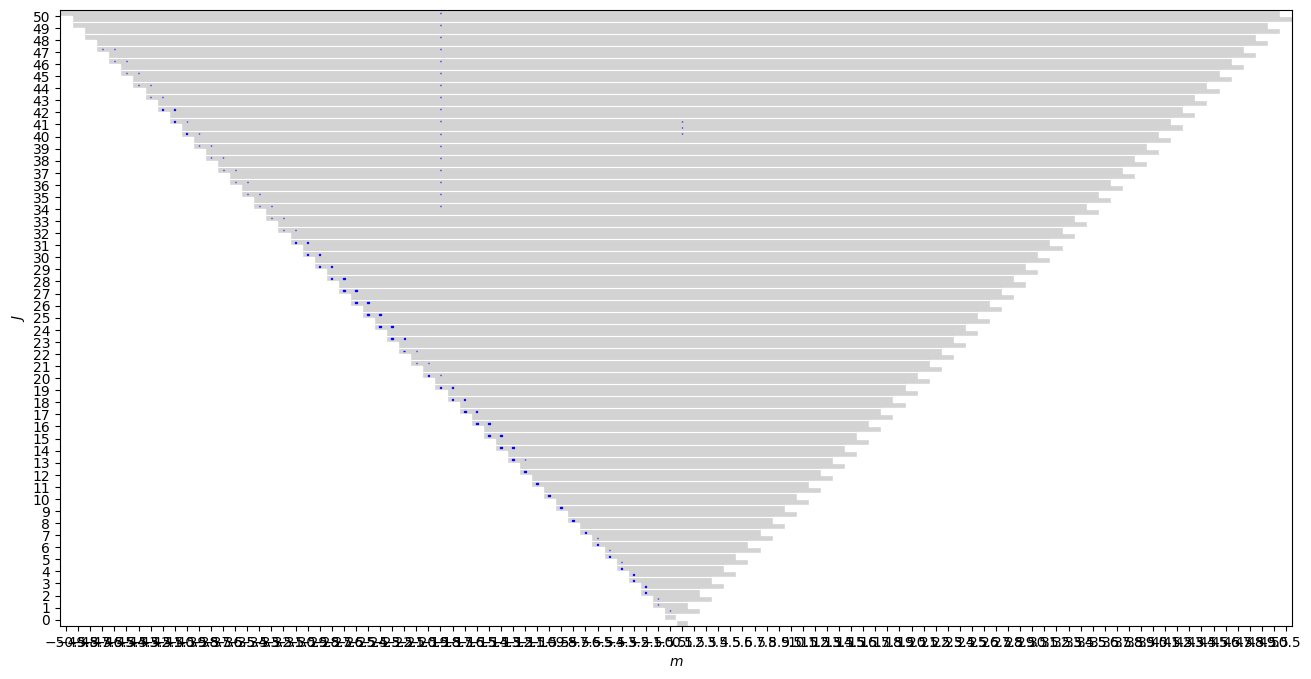

In [13]:
matrix = ut.heatmap_state_pop(mo1.state_df, j_max, normalize = False)